<a href="https://colab.research.google.com/github/amirmafzali/Neural_network-and-deep-learning_course/blob/main/Skin_lesion_HAM1000_VGG-19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!kaggle datasets download kmader/skin-cancer-mnist-ham10000  -p content/derm/

100% 5.20G/5.20G [03:51<00:00, 24.7MB/s]
100% 5.20G/5.20G [03:51<00:00, 24.2MB/s]


In [ ]:
!unzip content/derm/skin-cancer-mnist-ham10000.zip

In [38]:
import numpy as np     
import pandas as pd        
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
from cv2 import imread, resize 
import os
from keras.layers import Dense, Input, Flatten, Lambda, Dropout
from keras.models import Model
from keras.applications import VGG19
from keras.optimizers import Adam, Adagrad
from keras.applications.vgg19 import preprocess_input
from imblearn.over_sampling import RandomOverSampler 
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [20]:
df_skin = pd.read_csv('/content/HAM10000_metadata.csv')

df_skin.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [21]:
df_skin_bkl = df_skin[df_skin['dx'] == 'bkl']
df_skin_bcc = df_skin[df_skin['dx'] == 'bcc']
df_skin_df = df_skin[df_skin['dx'] == 'df']

df_skin2 = [df_skin_bkl, df_skin_bcc, df_skin_df]

df_skin2 = pd.concat(df_skin2)

df_skin2.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [22]:
lesion_type_dict = {
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'bkl': 0,
    'bcc': 1,
    'df': 2
}

lesion_names = ['Benign keratosis-like lesions ','Basal cell carcinoma',
               'Dermatofibroma']
lesion_names_short = ['bkl','bcc','df']

df_skin2['lesion_type']=df_skin2['dx'].map(lesion_type_dict)
df_skin2['lesion_ID'] = df_skin2['dx'].map(lesion_ID_dict)

df_skin2.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion_type,lesion_ID
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,0
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,0
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,Benign keratosis-like lesions,0
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,Benign keratosis-like lesions,0
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,Benign keratosis-like lesions,0
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,Benign keratosis-like lesions,0


In [23]:
x = []          
y = []

lista1 = os.listdir('/content/ham10000_images_part_1')
lista2 = os.listdir('/content/ham10000_images_part_2')


for i in range(len(lista1)):
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/content/ham10000_images_part_1/' + str(fname_image)
    z = df_skin2[df_skin2['image_id'] == fname_ID]
    if z.shape == (1,9):
      img = imread(file_to_read)                            
      img2 = resize(img,(64, 64))                           
      x.append(img2)
      output = np.array(df_skin2[df_skin2['image_id'] == fname_ID].lesion_ID)
      y.append(output[0])


for i in range(len(lista2)):
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/content/ham10000_images_part_2/' + str(fname_image)
    z = df_skin2[df_skin2['image_id'] == fname_ID]
    if z.shape == (1,9):
      img = imread(file_to_read)                            
      img2 = resize(img,(64, 64))                           
      x.append(img2)
      output = np.array(df_skin2[df_skin2['image_id'] == fname_ID].lesion_ID)
      y.append(output[0])

In [25]:
x = np.array(x)
y = np.array(y)
x = np.array(x).reshape(-1,12288)

print('Shape of X :',x.shape)

Shape of X : (1728, 12288)


In [27]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

x = np.array(x).reshape(-1,64,64,3)
print('Shape of X :',x.shape)

Shape of X : (3297, 64, 64, 3)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.20,random_state = 50)

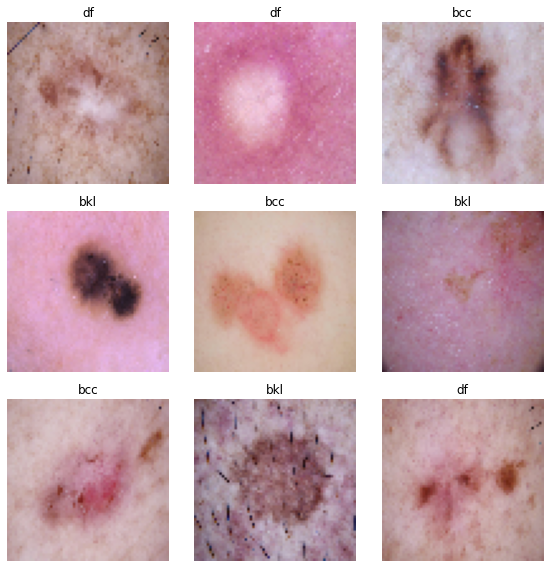

In [29]:
labels = {
    0: 'bkl',
    1: 'bcc',
    2: 'df'
}

W_grid = 3
L_grid = 3

fig = plt.figure(figsize=(8, 8))

for i in range(1,W_grid*L_grid+1) :
  random_image = np.random.randint(0,len(X_train))
  img = X_train[random_image]
  label = labels[y_train[random_image]]

  fig.add_subplot(W_grid,L_grid,i)
  plt.title(label)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
plt.tight_layout()
plt.show()

In [30]:
train_datagen = ImageDataGenerator(
    rescale = 1. /255,
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
    )

test_datagen = ImageDataGenerator(
    rescale = 1. /255
    )

train_datagen.fit(X_train)
test_datagen.fit(X_test)

In [31]:
y_train = to_categorical(y_train,num_classes = 3)
y_test = to_categorical(y_test,num_classes = 3)

In [33]:
vgg = VGG19(include_top=False,input_shape=[64,64,3])

80134624/80134624 [==============================] - 4s 0us/step


In [34]:
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(3,activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [35]:
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])

In [36]:
history_1=model.fit(X_train, y_train, batch_size=50,
                  epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
53/53 [==============================] - 12s 60ms/step - loss: 2.4771 - accuracy: 0.5965 - val_loss: 0.7901 - val_accuracy: 0.6803
Epoch 2/100
53/53 [==============================] - 2s 43ms/step - loss: 0.5970 - accuracy: 0.7490 - val_loss: 0.5353 - val_accuracy: 0.7833
Epoch 3/100
53/53 [==============================] - 2s 38ms/step - loss: 0.4047 - accuracy: 0.8146 - val_loss: 0.4403 - val_accuracy: 0.8227
Epoch 4/100
53/53 [==============================] - 2s 38ms/step - loss: 0.3021 - accuracy: 0.8779 - val_loss: 0.3896 - val_accuracy: 0.8758
Epoch 5/100
53/53 [==============================] - 2s 39ms/step - loss: 0.2522 - accuracy: 0.8900 - val_loss: 0.3710 - val_accuracy: 0.8758
Epoch 6/100
53/53 [==============================] - 2s 38ms/step - loss: 0.2071 - accuracy: 0.9204 - val_loss: 0.3427 - val_accuracy: 0.9000
Epoch 7/100
53/53 [==============================] - 2s 43ms/step - loss: 0.1595 - accuracy: 0.9393 - val_loss: 0.3242 - val_accuracy: 0.9076
Epoch

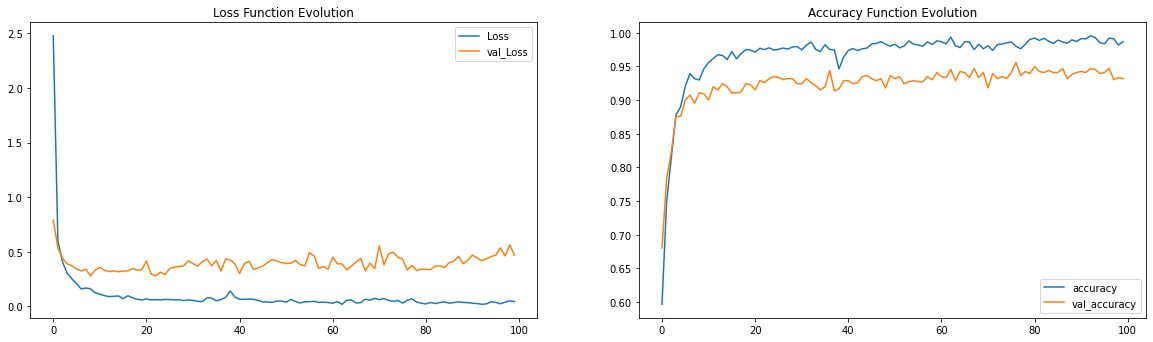

In [37]:
plt.figure(figsize=(20,25))

plt.subplot(4, 2, 1)
plt.plot(history_1.history['loss'], label='Loss')
plt.plot(history_1.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_1.history['accuracy'], label='accuracy')
plt.plot(history_1.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

In [39]:
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)
print('\naccuracy of second model = ',accuracy_score(y_test_arg, Y_pred),"\n")
print('recall of second model = ',recall_score(y_test_arg, Y_pred,average='macro'),'\n')
print('f1 of second model =',f1_score(y_test_arg, Y_pred,average='macro'),'\n')
print('precision of second model = ',precision_score(y_test_arg, Y_pred,average='macro'))

21/21 [==============================] - 1s 37ms/step

accuracy of second model =  0.9318181818181818 

recall of second model =  0.9291446208112873 

f1 of second model = 0.9291944590929808 

precision of second model =  0.9313061096245575


21/21 [==============================] - 0s 20ms/step


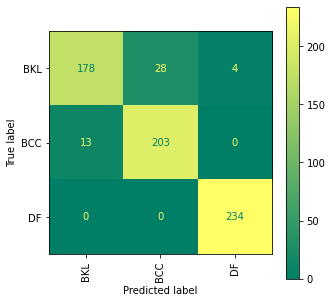

In [42]:

labels = ['BKL','BCC', 'DF']
y_test_arg=np.argmax(y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)
cm = confusion_matrix(y_test_arg, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


fig, ax = plt.subplots(figsize=(5, 5))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()
     